In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


class BasicBlock(nn.Module):
    """残差跳联基础块：由2个3×3卷积层构成，缓解深度网络梯度消失问题"""
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        # 主路径：卷积→批归一化→激活→卷积→批归一化
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)  # 统一激活函数实例，减少重复创建
        self.downsample = downsample  # 维度匹配模块（通道/步长不匹配时使用）

    def forward(self, x):
        identity = x  # 恒等映射（残差跳联路径）
        
        # 主路径前向传播
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # 若需维度匹配，对恒等路径做下采样
        if self.downsample is not None:
            identity = self.downsample(identity)
        
        # 残差连接：主路径输出 + 恒等路径输出
        out += identity
        out = self.relu(out)
        return out


class ResNet18(nn.Module):
    """ResNet-18完整模型，适配CIFAR-10图像分类任务"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.in_channels = 64  # 初始输入通道数（conv1输出通道）
        
        # 初始卷积层：7×7卷积降维+批归一化+激活+3×3最大池化
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # 残差块组：conv2_x~conv5_x（对应不同特征图尺寸）
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)  # 56×56特征图，2个残差块
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2) # 28×28特征图，2个残差块
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2) # 14×14特征图，2个残差块
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2) # 7×7特征图，2个残差块
        
        # 分类头：全局自适应平均池化+全连接层（输出类别数=10）
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # 动态适配输入尺寸，输出1×1特征图
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        """批量创建残差块组，自动处理维度匹配逻辑"""
        downsample = None
        # 当步长≠1或输入输出通道不匹配时，创建下采样模块
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        # 构建残差块列表（第一个块需处理维度匹配，后续块直接复用通道）
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels  # 更新后续块的输入通道数
        layers.extend([block(self.in_channels, out_channels) for _ in range(1, blocks)])
        
        return nn.Sequential(*layers)

    def forward(self, x):
        """模型前向传播流程"""
        # 初始特征提取
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 残差块组特征提取
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # 分类头计算
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # 展平特征（跳过batch维度）
        x = self.fc(x)
        return x


def load_cifar10(batch_size=64, num_workers=2):
    """加载并预处理CIFAR-10数据集（含训练集增强与验证集标准化）"""
    # CIFAR-10数据集标准化参数（基于数据集全局统计）
    mean, std = (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)
    
    # 训练集预处理：随机裁剪+水平翻转（数据增强）+标准化
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),  # 适配CIFAR-10的32×32尺寸
        transforms.RandomHorizontalFlip(p=0.5),# 50%概率水平翻转，提升泛化性
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    
    # 验证集预处理：仅标准化（避免数据分布偏移，保证评估客观性）
    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # 加载数据集（自动下载至指定路径）
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=val_transform)

    # 构建数据加载器（支持多线程加载，pin_memory加速GPU数据传输）
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )
    
    return train_loader, val_loader


def train_resnet18(num_epochs=15, batch_size=128, lr=0.01, num_workers=2):
    """ResNet-18训练流程：支持GPU加速、学习率调度与训练/验证指标记录"""
    # 动态设备选择（优先使用GPU，无GPU时自动切换至CPU）
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"训练设备：{device}")

    # 初始化核心组件（模型+损失函数+优化器+学习率调度）
    model = ResNet18(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()  # 分类任务标准损失函数
    optimizer = optim.SGD(  # SGD+动量+权重衰减，提升训练稳定性与泛化性
        model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4
    )
    scheduler = optim.lr_scheduler.StepLR(  # 学习率步进衰减（每5轮×0.1）
        optimizer, step_size=5, gamma=0.1
    )

    # 加载数据集（CPU环境下禁用多线程，避免线程冲突）
    if device.type == 'cpu':
        num_workers = 0
    train_loader, val_loader = load_cifar10(batch_size=batch_size, num_workers=num_workers)

    # 指标记录容器（训练/验证的损失与准确率）
    metrics = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    # 训练循环
    for epoch in range(num_epochs):
        model.train()  # 切换至训练模式（启用批归一化/ dropout）
        train_loss, correct_train, total_train = 0.0, 0, 0

        # 训练批次迭代
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # 数据移至目标设备
            
            # 梯度清零→前向传播→损失计算→反向传播→参数更新
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # 累加训练损失与正确预测数
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # 计算训练集平均指标
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_acc = 100 * correct_train / total_train
        metrics['train_loss'].append(avg_train_loss)
        metrics['train_acc'].append(train_acc)

        # 验证阶段（禁用梯度计算，减少内存占用与计算开销）
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                # 累加验证损失与正确预测数
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # 计算验证集平均指标
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100 * correct_val / total_val
        metrics['val_loss'].append(avg_val_loss)
        metrics['val_acc'].append(val_acc)

        # 更新学习率
        scheduler.step()

        # 打印当前轮次指标
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  训练：损失={avg_train_loss:.4f} | 准确率={train_acc:.2f}%")
        print(f"  验证：损失={avg_val_loss:.4f} | 准确率={val_acc:.2f}%")
        print(f"  当前学习率：{scheduler.get_last_lr()[0]:.6f}")

        # GPU缓存清理（避免内存累积导致溢出）
        if device.type == 'cuda':
            torch.cuda.empty_cache()

    # 保存模型参数（仅保存权重，节省存储空间）
    torch.save(model.state_dict(), './resnet18_cifar10.pth')
    print("\n模型权重已保存：resnet18_cifar10.pth")

    return metrics


def plot_metrics(metrics):
    """绘制训练/验证的损失与准确率曲线，支持中文显示"""
    # 配置中文显示（适配多操作系统）
    plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei', 'SimHei', 'Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False

    # 创建双子图布局
    plt.figure(figsize=(10, 4))
    
    # 子图1：损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='训练损失', color='#1f77b4', linewidth=1.5)
    plt.plot(metrics['val_loss'], label='验证损失', color='#ff7f0e', linewidth=1.5)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('ResNet-18 损失变化曲线')
    plt.legend()
    plt.grid(alpha=0.3)  # 浅网格辅助读数
    
    # 子图2：准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_acc'], label='训练准确率', color='#1f77b4', linewidth=1.5)
    plt.plot(metrics['val_acc'], label='验证准确率', color='#ff7f0e', linewidth=1.5)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('ResNet-18 准确率变化曲线')
    plt.legend()
    plt.grid(alpha=0.3)

    # 调整布局并保存图像（避免标签截断，平衡清晰度与文件大小）
    plt.tight_layout()
    plt.savefig('./resnet18_cifar10_metrics.png', dpi=150, bbox_inches='tight')
    print("指标曲线已保存：resnet18_cifar10_metrics.png")


# 主函数：一键执行训练与指标可视化
if __name__ == "__main__":
    # 训练参数配置（GPU环境下约8-12分钟完成15轮训练）
    train_metrics = train_resnet18(
        num_epochs=15,
        batch_size=128,
        lr=0.01,
        num_workers=2
    )
    # 可视化训练过程中的指标变化
    plot_metrics(train_metrics)

训练设备：cuda
Epoch [1/15]
  训练：损失=1.6496 | 准确率=40.35%
  验证：损失=1.3671 | 准确率=51.67%
  当前学习率：0.010000
Epoch [2/15]
  训练：损失=1.2749 | 准确率=54.54%
  验证：损失=1.2518 | 准确率=59.48%
  当前学习率：0.010000
Epoch [3/15]
  训练：损失=1.1052 | 准确率=61.34%
  验证：损失=1.0809 | 准确率=61.73%
  当前学习率：0.010000
Epoch [4/15]
  训练：损失=0.9766 | 准确率=65.64%
  验证：损失=0.9076 | 准确率=68.78%
  当前学习率：0.010000
Epoch [5/15]
  训练：损失=0.8873 | 准确率=68.72%
  验证：损失=0.8439 | 准确率=70.87%
  当前学习率：0.001000
Epoch [6/15]
  训练：损失=0.7229 | 准确率=74.43%
  验证：损失=0.6901 | 准确率=76.00%
  当前学习率：0.001000
Epoch [7/15]
  训练：损失=0.6845 | 准确率=75.78%
  验证：损失=0.6752 | 准确率=76.25%
  当前学习率：0.001000
Epoch [8/15]
  训练：损失=0.6666 | 准确率=76.47%
  验证：损失=0.6627 | 准确率=77.17%
  当前学习率：0.001000
Epoch [9/15]
  训练：损失=0.6474 | 准确率=77.26%
  验证：损失=0.6573 | 准确率=76.98%
  当前学习率：0.001000
Epoch [10/15]
  训练：损失=0.6383 | 准确率=77.38%
  验证：损失=0.6429 | 准确率=78.02%
  当前学习率：0.000100
Epoch [11/15]
  训练：损失=0.6162 | 准确率=78.36%
  验证：损失=0.6349 | 准确率=78.02%
  当前学习率：0.000100
Epoch [12/15]
  训练：损失=0.6057 | 准确率=78.65%


: 

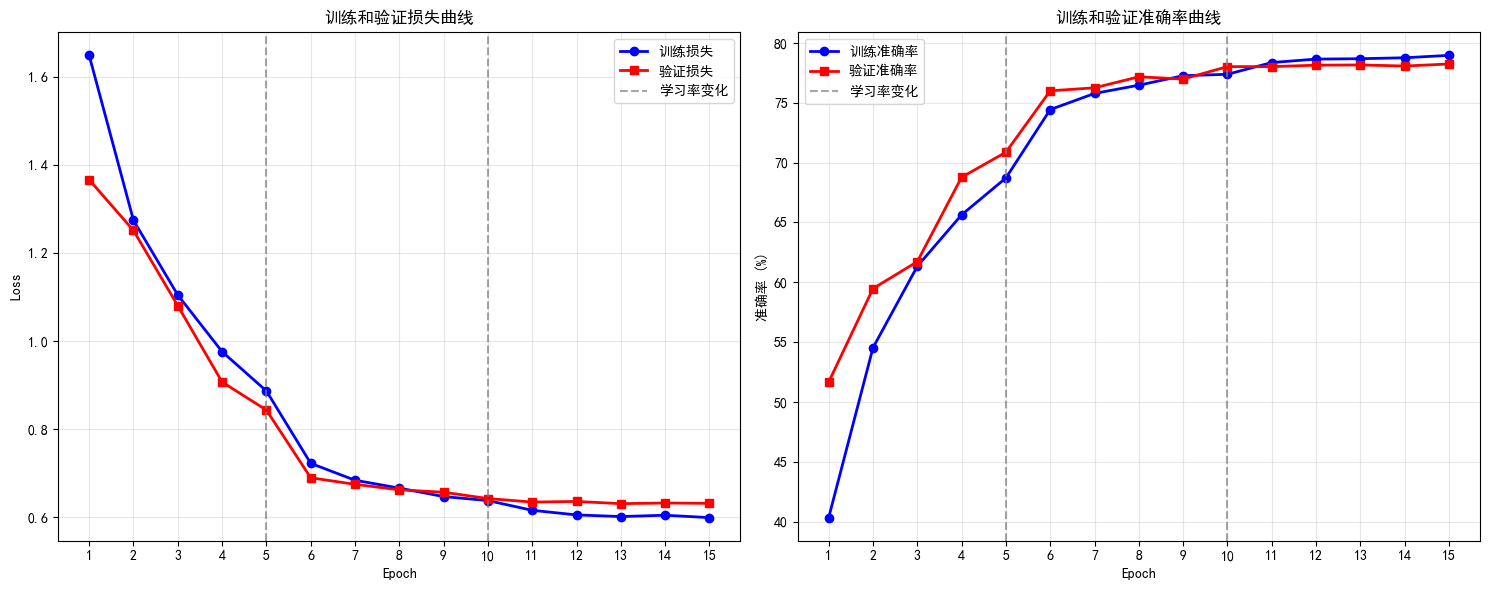

最终结果:
训练准确率: 78.96%
验证准确率: 78.24%
训练损失: 0.5996
验证损失: 0.6320


In [2]:
import matplotlib.pyplot as plt

# 设置中文显示
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False

# 数据从训练日志中提取
epochs = list(range(1, 16))

# 训练损失
train_loss = [1.6496, 1.2749, 1.1052, 0.9766, 0.8873, 0.7229, 0.6845, 0.6666, 0.6474, 0.6383, 0.6162, 0.6057, 0.6020, 0.6050, 0.5996]

# 验证损失
val_loss = [1.3671, 1.2518, 1.0809, 0.9076, 0.8439, 0.6901, 0.6752, 0.6627, 0.6573, 0.6429, 0.6349, 0.6363, 0.6313, 0.6328, 0.6320]

# 训练准确率
train_acc = [40.35, 54.54, 61.34, 65.64, 68.72, 74.43, 75.78, 76.47, 77.26, 77.38, 78.36, 78.65, 78.68, 78.76, 78.96]

# 验证准确率
val_acc = [51.67, 59.48, 61.73, 68.78, 70.87, 76.00, 76.25, 77.17, 76.98, 78.02, 78.02, 78.14, 78.16, 78.07, 78.24]

# 学习率变化点
lr_changes = [5, 10]  # 第5和第10epoch学习率发生变化

# 创建图表
plt.figure(figsize=(15, 6))

# 1. Loss曲线
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='训练损失', linewidth=2, marker='o')
plt.plot(epochs, val_loss, 'r-', label='验证损失', linewidth=2, marker='s')

# 标记学习率变化点
for change_epoch in lr_changes:
    plt.axvline(x=change_epoch, color='gray', linestyle='--', alpha=0.7, label='学习率变化' if change_epoch == lr_changes[0] else "")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('训练和验证损失曲线')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(epochs)

# 2. Accuracy曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='训练准确率', linewidth=2, marker='o')
plt.plot(epochs, val_acc, 'r-', label='验证准确率', linewidth=2, marker='s')

# 标记学习率变化点
for change_epoch in lr_changes:
    plt.axvline(x=change_epoch, color='gray', linestyle='--', alpha=0.7, label='学习率变化' if change_epoch == lr_changes[0] else "")

plt.xlabel('Epoch')
plt.ylabel('准确率 (%)')
plt.title('训练和验证准确率曲线')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(epochs)

plt.tight_layout()
plt.show()

# 打印最终结果
print(f"最终结果:")
print(f"训练准确率: {train_acc[-1]:.2f}%")
print(f"验证准确率: {val_acc[-1]:.2f}%")
print(f"训练损失: {train_loss[-1]:.4f}")
print(f"验证损失: {val_loss[-1]:.4f}")

In [3]:
import torch
# 查看当前GPU显存占用（单位：MB）
used_mem = torch.cuda.memory_allocated(0) / 1024 / 1024  # 0对应cuda:0设备
print(f"cuda:0当前显存占用：{used_mem:.2f} MB")
# 若输出低于100MB，说明内存已成功释放（仅保留PyTorch基础缓存）

cuda:0当前显存占用：0.00 MB
